# Projeto de Conversor Flyback DC-DC Isolado

Este notebook apresenta o projeto de um conversor Flyback isolado, que utiliza um transformador para:

1. **Isolamento galvânico** entre entrada e saída
2. **Armazenamento de energia** na indutância magnetizante
3. **Conversão step-up de tensão** com isolamento

## Topologia do Flyback (com Lm em série)

```
         Lm        T1 (n:1)
Vin ───LLLL──┬──●────●──┬── Diode ──┬── Vout
             │  Np   Ns │           │
            SW          │         Cout
             │          │           │
GND ─────────┴──────────┴───────────┴── GND
```

**Função de transferência:**
$$V_{out} = \frac{V_{in}}{n \cdot (1-D)}$$

Esta topologia opera como um **boost isolado**, sempre produzindo Vout ≥ Vin/n.

In [15]:
from pathlib import Path
import sys

_root = Path.cwd()
_candidate_paths = []
for _ in range(6):
    for _rel in (('build-test', 'python'), ('build', 'python')):
        candidate = _root / _rel[0] / _rel[1]
        if candidate.is_dir():
            _candidate_paths.append(candidate)
    _root = _root.parent

_unique_candidates = []
_seen = set()
for candidate in _candidate_paths:
    cstr = str(candidate)
    if cstr in _seen:
        continue
    _seen.add(cstr)
    _unique_candidates.append(candidate)

_bootstrap_error = None
for candidate in _unique_candidates:
    cstr = str(candidate)
    if cstr not in sys.path:
        sys.path.insert(0, cstr)
    try:
        import pulsim  # noqa: F401
        break
    except Exception as exc:
        _bootstrap_error = exc
        if cstr in sys.path:
            sys.path.remove(cstr)
else:
    if _bootstrap_error is not None:
        raise _bootstrap_error

# ============================================================
# SETUP E IMPORTS
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import time

import pulsim as ps

print(f"PulsimCore version: {ps.__version__}")
print("="*60)
print("PROJETO DE CONVERSOR FLYBACK DC-DC ISOLADO")
print("="*60)

PulsimCore version: 0.2.0
PROJETO DE CONVERSOR FLYBACK DC-DC ISOLADO


## 1. Especificações do Projeto

Aplicação típica: Conversor 24V para 48V isolado (comum em telecom/datacenter)

In [16]:
# ============================================================
# ESPECIFICAÇÕES DO FLYBACK
# ============================================================

# Tensões
Vin_nom = 24.0       # Tensão de entrada nominal [V]
Vin_min = 20.0       # Tensão de entrada mínima [V]
Vin_max = 28.0       # Tensão de entrada máxima [V]
Vout = 48.0          # Tensão de saída [V] (isolada, 2x boost)

# Potência
Pout = 24.0          # Potência de saída [W]
Iout = Pout / Vout   # Corrente de saída [A]

# Frequência de chaveamento
fsw = 100e3          # Frequência [Hz]
Tsw = 1/fsw          # Período [s]

# Eficiência estimada
eta = 0.85           # 85% (típico para Flyback)

print("ESPECIFICAÇÕES DO FLYBACK")
print("="*50)
print(f"\nEntrada:")
print(f"  Vin nominal: {Vin_nom}V")
print(f"  Vin range: {Vin_min}V - {Vin_max}V")
print(f"\nSaída (isolada):")
print(f"  Vout: {Vout}V")
print(f"  Pout: {Pout}W")
print(f"  Iout: {Iout:.2f}A")
print(f"\nChaveamento:")
print(f"  fsw: {fsw/1e3:.0f}kHz")
print(f"  Tsw: {Tsw*1e6:.1f}µs")

ESPECIFICAÇÕES DO FLYBACK

Entrada:
  Vin nominal: 24.0V
  Vin range: 20.0V - 28.0V

Saída (isolada):
  Vout: 48.0V
  Pout: 24.0W
  Iout: 0.50A

Chaveamento:
  fsw: 100kHz
  Tsw: 10.0µs


## 2. Cálculos do Flyback

### Relação de conversão (CCM)

$$V_{out} = \frac{V_{in}}{n \cdot (1-D)}$$

Onde:
- $D$ = duty cycle
- $n$ = relação de espiras (Np/Ns)

In [17]:
# ============================================================
# RELAÇÃO DE ESPIRAS E DUTY CYCLE
# ============================================================

# Escolher n = 1 para isolamento 1:1 (simplifica análise)
n = 1

# Calcular D a partir da função de transferência: Vout = Vin / (n*(1-D))
# n*(1-D) = Vin/Vout
# 1-D = Vin/(n*Vout)
# D = 1 - Vin/(n*Vout)
D_nom = 1 - Vin_nom / (n * Vout)
D_max = 1 - Vin_min / (n * Vout)  # Vin mínimo -> D máximo
D_min = 1 - Vin_max / (n * Vout)  # Vin máximo -> D mínimo

print("RELAÇÃO DE ESPIRAS E DUTY")
print("="*50)
print(f"\nRelação de espiras: n = {n}:1")
print(f"\nDuty Cycle:")
print(f"  D nominal (Vin={Vin_nom}V): {D_nom:.2%}")
print(f"  D mínimo (Vin={Vin_max}V): {D_min:.2%}")
print(f"  D máximo (Vin={Vin_min}V): {D_max:.2%}")

# Verificar tensão de saída
Vout_calc = Vin_nom / (n * (1 - D_nom))
print(f"\nVerificação: Vout = {Vout_calc:.2f}V (alvo: {Vout}V)")

RELAÇÃO DE ESPIRAS E DUTY

Relação de espiras: n = 1:1

Duty Cycle:
  D nominal (Vin=24.0V): 50.00%
  D mínimo (Vin=28.0V): 41.67%
  D máximo (Vin=20.0V): 58.33%

Verificação: Vout = 48.00V (alvo: 48.0V)


In [18]:
# ============================================================
# INDUTÂNCIA MAGNETIZANTE
# ============================================================

# Ripple de corrente no primário
delta_Ip_percent = 0.4  # 40% de ripple (CCM garantido)

# Corrente média no primário
Ip_avg = Pout / (eta * Vin_nom)  # Pin = Pout/eta

# Corrente de pico
delta_Ip = delta_Ip_percent * Ip_avg
Ip_peak = Ip_avg + delta_Ip / 2

# Cálculo de Lm
# Durante ton: V_Lm = Vin, di = Vin * ton / Lm
# delta_Ip = Vin * D * Tsw / Lm
# Lm = Vin * D * Tsw / delta_Ip
Lm = Vin_nom * D_nom * Tsw / delta_Ip

# Valor comercial
Lm_comercial = 100e-6  # 100µH

print("INDUTÂNCIA MAGNETIZANTE")
print("="*50)
print(f"\nCorrente no primário:")
print(f"  Ip média: {Ip_avg:.2f}A")
print(f"  ΔIp: {delta_Ip:.2f}A ({delta_Ip_percent*100:.0f}%)")
print(f"  Ip pico: {Ip_peak:.2f}A")
print(f"\nIndutância:")
print(f"  Lm calculado: {Lm*1e6:.1f}µH")
print(f"  Lm comercial: {Lm_comercial*1e6:.0f}µH")

# Usar valor comercial
Lm = Lm_comercial

INDUTÂNCIA MAGNETIZANTE

Corrente no primário:
  Ip média: 1.18A
  ΔIp: 0.47A (40%)
  Ip pico: 1.41A

Indutância:
  Lm calculado: 255.0µH
  Lm comercial: 100µH


In [19]:
# ============================================================
# CAPACITOR DE SAÍDA
# ============================================================

# Ripple de tensão
delta_Vout_percent = 0.02  # 2%
delta_Vout = delta_Vout_percent * Vout

# C_out = Iout * D * Tsw / delta_Vout
C_out_min = Iout * D_max * Tsw / delta_Vout

# Valor comercial com margem
C_out = 100e-6  # 100µF

# Carga
R_load = Vout / Iout

print("CAPACITOR DE SAÍDA")
print("="*50)
print(f"\nRipple:")
print(f"  ΔVout: {delta_Vout*1e3:.0f}mV ({delta_Vout_percent*100:.0f}%)")
print(f"\nCapacitor:")
print(f"  C mínimo: {C_out_min*1e6:.1f}µF")
print(f"  C escolhido: {C_out*1e6:.0f}µF")
print(f"\nCarga:")
print(f"  R_load: {R_load:.1f}Ω")

CAPACITOR DE SAÍDA

Ripple:
  ΔVout: 960mV (2%)

Capacitor:
  C mínimo: 3.0µF
  C escolhido: 100µF

Carga:
  R_load: 96.0Ω


## 3. Simulação em Malha Aberta

In [20]:
# ============================================================
# CONSTRUÇÃO DO CIRCUITO FLYBACK
# ============================================================

def create_flyback_circuit(Vin, Lm, n, C_out, R_load, fsw, duty):
    """
    Cria circuito do Flyback converter (isolated boost).
    
    Topologia:
    Vin -> Lm -> n_sw -> MOSFET -> GND
                    |
              Transformer (n:1)
                    |
                n_sec -> Diode -> n_out -> Cout/Rload -> GND
    """
    ckt = ps.Circuit()
    
    # Nós
    n_in = ckt.add_node("in")        # Entrada (após Vin)
    n_sw = ckt.add_node("sw")        # Nó de chaveamento
    n_sec = ckt.add_node("sec")      # Secundário do transformer
    n_out = ckt.add_node("out")      # Saída
    n_ctrl = ckt.add_node("ctrl")    # Sinal PWM
    
    # Fonte de entrada DC
    ckt.add_voltage_source("Vin", n_in, -1, Vin)
    
    # Indutância magnetizante (armazena energia)
    ckt.add_inductor("Lm", n_in, n_sw, Lm)
    
    # MOSFET low-side (como no Boost)
    mosfet_params = ps.MOSFETParams()
    mosfet_params.vth = 2.0
    mosfet_params.kp = 10.0
    mosfet_params.g_off = 1e-6
    ckt.add_mosfet("M1", n_ctrl, n_sw, -1, mosfet_params)
    
    # Transformer: n_sw (primário) acoplado a n_sec (secundário)
    ckt.add_transformer("T1", n_sw, -1, n_sec, -1, n)
    
    # Diodo retificador
    ckt.add_diode("D1", n_sec, n_out, g_on=100.0, g_off=1e-9)
    
    # Capacitor de saída
    ckt.add_capacitor("Cout", n_out, -1, C_out)
    
    # Carga
    ckt.add_resistor("Rload", n_out, -1, R_load)
    
    # PWM
    pwm_params = ps.PWMParams()
    pwm_params.v_high = 10.0
    pwm_params.v_low = 0.0
    pwm_params.frequency = fsw
    pwm_params.duty = duty
    ckt.add_pwm_voltage_source("Vpwm", n_ctrl, -1, pwm_params)
    
    nodes = {'n_in': n_in, 'n_sw': n_sw, 'n_sec': n_sec, 'n_out': n_out, 'n_ctrl': n_ctrl}
    return ckt, nodes

# Criar circuito
ckt, nodes = create_flyback_circuit(Vin_nom, Lm, n, C_out, R_load, fsw, D_nom)

print("CIRCUITO FLYBACK CRIADO")
print("="*50)
print(f"  Nós: {ckt.num_nodes()}")
print(f"  Branches: {ckt.num_branches()}")
print(f"  Tamanho do sistema: {ckt.system_size()}")
print(f"  Duty cycle: {D_nom:.2%}")
print(f"  Turns ratio: {n}:1")

CIRCUITO FLYBACK CRIADO
  Nós: 5
  Branches: 5
  Tamanho do sistema: 10
  Duty cycle: 50.00%
  Turns ratio: 1:1


In [21]:
# ============================================================
# SIMULAÇÃO TRANSITÓRIA - MALHA ABERTA
# ============================================================

print("SIMULAÇÃO EM MALHA ABERTA")
print("="*50)

# Parâmetros de simulação (mais períodos para atingir regime)
n_periods = 1000
dt = Tsw / 100
t_sim = n_periods * Tsw

print(f"\nSimulação:")
print(f"  Períodos: {n_periods}")
print(f"  Tempo total: {t_sim*1e3:.1f}ms")
print(f"  Timestep: {dt*1e9:.0f}ns")

# Estado inicial
x0 = np.zeros(ckt.system_size())

# Newton options
newton_opts = ps.NewtonOptions()
newton_opts.max_iterations = 100

# Executar simulação
print(f"\nSimulando...")
start_time = time.time()

times, states, success, msg = ps.run_transient(ckt, 0.0, t_sim, dt, x0, newton_opts)

elapsed = time.time() - start_time
print(f"\nResultado: {'SUCESSO' if success else 'FALHA'}")
print(f"Mensagem: {msg}")
print(f"Tempo de execução: {elapsed:.2f}s")
print(f"Pontos simulados: {len(times)}")

SIMULAÇÃO EM MALHA ABERTA

Simulação:
  Períodos: 1000
  Tempo total: 10.0ms
  Timestep: 100ns

Simulando...

Resultado: SUCESSO
Mensagem: Transient completed
Tempo de execução: 6.80s
Pontos simulados: 193001


In [22]:
# ============================================================
# ANÁLISE DOS RESULTADOS
# ============================================================

if success and len(times) > 0:
    times_arr = np.array(times)
    states_arr = np.array(states)
    
    # Extrair tensões
    n_in = nodes['n_in']
    n_sw = nodes['n_sw']
    n_sec = nodes['n_sec']
    n_out = nodes['n_out']
    
    v_in = states_arr[:, n_in]
    v_sw = states_arr[:, n_sw]
    v_sec = states_arr[:, n_sec]
    v_out = states_arr[:, n_out]
    
    # Regime permanente (últimos 10%)
    idx_steady = int(0.9 * len(times_arr))
    v_out_steady = v_out[idx_steady:]
    
    v_out_avg = np.mean(v_out_steady)
    v_out_max = np.max(v_out_steady)
    v_out_min = np.min(v_out_steady)
    ripple = v_out_max - v_out_min
    
    # Vout esperado
    Vout_expected = Vin_nom / (n * (1 - D_nom))
    
    print("RESULTADOS - MALHA ABERTA")
    print("="*50)
    print(f"\nTensão de saída (regime permanente):")
    print(f"  Vout médio: {v_out_avg:.2f}V")
    print(f"  Vout esperado: {Vout_expected:.2f}V")
    print(f"  Erro: {(v_out_avg-Vout_expected)/Vout_expected*100:+.1f}%")
    print(f"\nRipple:")
    print(f"  ΔVout: {ripple*1e3:.1f}mV ({ripple/v_out_avg*100:.2f}%)")
    print(f"\nTensão no switch (peak):")
    print(f"  Vsw peak: {np.max(v_sw[idx_steady:]):.1f}V")
else:
    print("Simulação falhou ou sem dados.")

RESULTADOS - MALHA ABERTA

Tensão de saída (regime permanente):
  Vout médio: 48.73V
  Vout esperado: 48.00V
  Erro: +1.5%

Ripple:
  ΔVout: 2081.5mV (4.27%)

Tensão no switch (peak):
  Vsw peak: 49.8V


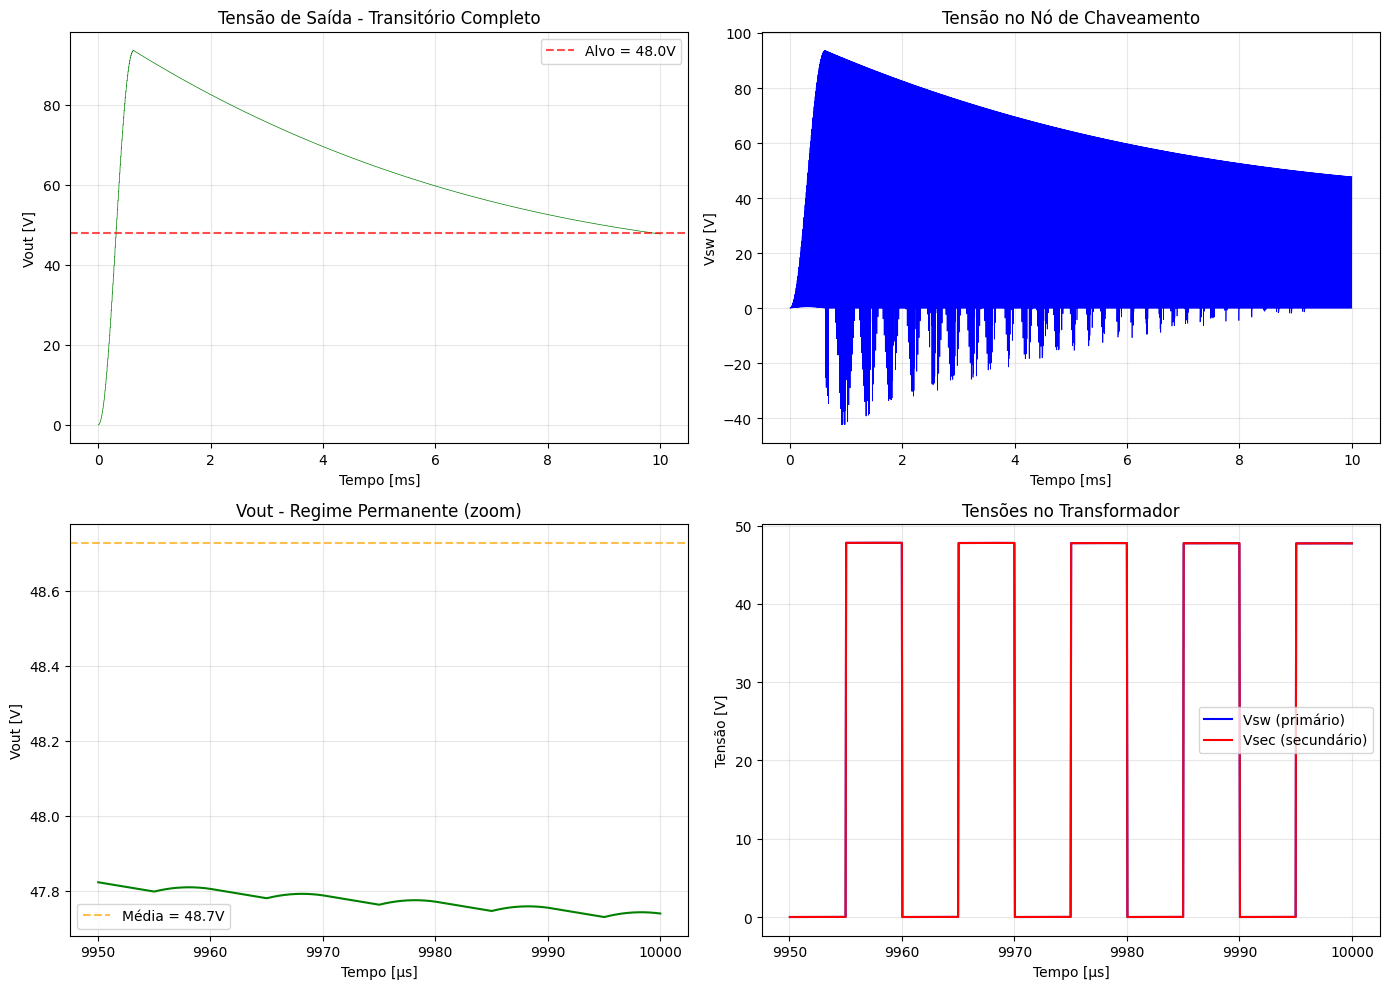

In [23]:
# ============================================================
# GRÁFICOS
# ============================================================

if success and len(times) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Vout completo
    ax = axes[0, 0]
    ax.plot(times_arr*1e3, v_out, 'g-', linewidth=0.5)
    ax.axhline(Vout, color='r', linestyle='--', alpha=0.7, label=f'Alvo = {Vout}V')
    ax.set_xlabel('Tempo [ms]')
    ax.set_ylabel('Vout [V]')
    ax.set_title('Tensão de Saída - Transitório Completo')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Vsw (switch node)
    ax = axes[0, 1]
    ax.plot(times_arr*1e3, v_sw, 'b-', linewidth=0.5)
    ax.set_xlabel('Tempo [ms]')
    ax.set_ylabel('Vsw [V]')
    ax.set_title('Tensão no Nó de Chaveamento')
    ax.grid(True, alpha=0.3)
    
    # Zoom nos últimos períodos
    n_zoom = int(10 * Tsw / dt)
    ax = axes[1, 0]
    ax.plot(times_arr[-n_zoom:]*1e6, v_out[-n_zoom:], 'g-', linewidth=1.5)
    ax.axhline(v_out_avg, color='orange', linestyle='--', alpha=0.7, label=f'Média = {v_out_avg:.1f}V')
    ax.set_xlabel('Tempo [µs]')
    ax.set_ylabel('Vout [V]')
    ax.set_title('Vout - Regime Permanente (zoom)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Vsw e Vsec zoom
    ax = axes[1, 1]
    ax.plot(times_arr[-n_zoom:]*1e6, v_sw[-n_zoom:], 'b-', linewidth=1.5, label='Vsw (primário)')
    ax.plot(times_arr[-n_zoom:]*1e6, v_sec[-n_zoom:], 'r-', linewidth=1.5, label='Vsec (secundário)')
    ax.set_xlabel('Tempo [µs]')
    ax.set_ylabel('Tensão [V]')
    ax.set_title('Tensões no Transformador')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 4. Simulação em Malha Fechada com PI

In [24]:
# ============================================================
# CONTROLADOR PI
# ============================================================

# Ganhos PI ajustados para malha fechada em chaveamento
Kp = 0.003
Ki = 20.0

print("CONTROLADOR PI")
print("="*50)
print(f"  Kp = {Kp}")
print(f"  Ki = {Ki}")


CONTROLADOR PI
  Kp = 0.003
  Ki = 20.0


In [25]:
# ============================================================
# SIMULACAO EM MALHA FECHADA
# ============================================================

def simulate_flyback_closed_loop(
    Vin,
    Lm,
    n,
    C_out,
    R_load,
    fsw,
    V_ref,
    Kp,
    Ki,
    n_periods=500,
    dt_factor=180,
    D_init=None,
    D_min=0.10,
    D_max=0.65,
    softstart_periods=1,
    duty_slew=0.006,
):
    """
    Simula Flyback em malha fechada com controlador PI.

    Observacao: na abordagem de 1 periodo por chamada, o Newton precisa
    de margem maior para continuar convergindo por centenas de periodos.
    """
    Tsw = 1 / fsw
    dt_base = Tsw / dt_factor

    # Duty nominal aproximado para iniciar mais perto do ponto de operacao
    D_nom_ctrl = float(np.clip(1.0 - Vin / (n * V_ref), D_min, D_max))
    if D_init is None:
        D_init = D_nom_ctrl

    pi = ps.PIController(Kp, Ki, output_min=D_min, output_max=D_max)

    time_hist = []
    vout_hist = []
    duty_hist = []
    error_hist = []
    vref_hist = []

    current_duty = float(np.clip(D_init, D_min, D_max))
    t = 0.0
    x = None

    def run_one_period(circuit, t_start, x_start, dt_try):
        attempts = (
            (dt_try, 180),
            (dt_try * 0.75, 260),
            (dt_try * 0.50, 360),
        )

        last = (None, None, False, "Unknown failure")
        for dt_local, max_iters in attempts:
            opts = ps.NewtonOptions()
            opts.max_iterations = max_iters
            last = ps.run_transient(
                circuit,
                t_start,
                t_start + Tsw,
                dt_local,
                x_start,
                opts,
            )
            if last[2]:
                return last
        return last

    print(f"Simulando {n_periods} periodos com PI...")

    for period in range(n_periods):
        # Soft-start opcional da referencia (1 = desativado)
        alpha = min(1.0, (period + 1) / max(1, softstart_periods))
        vref_eff = V_ref * alpha

        ckt, nodes = create_flyback_circuit(Vin, Lm, n, C_out, R_load, fsw, current_duty)

        if x is None:
            x = np.zeros(ckt.system_size())

        times, states, ok, msg = run_one_period(ckt, t, x, dt_base)

        if not ok:
            print(f"Falha no periodo {period}: {msg}")
            return {
                'time': np.array(time_hist),
                'vout': np.array(vout_hist),
                'duty': np.array(duty_hist),
                'error': np.array(error_hist),
                'vref_eff': np.array(vref_hist),
                'success': False,
                'message': msg,
                'fail_period': period,
            }

        states_arr = np.array(states)
        x = states_arr[-1].copy()
        t += Tsw

        V_out_period = float(np.mean(states_arr[:, nodes['n_out']]))
        error = vref_eff - V_out_period

        duty_cmd = float(pi.update(error, t))

        # Limita variacao ciclo a ciclo do duty
        delta_d = np.clip(duty_cmd - current_duty, -duty_slew, duty_slew)
        current_duty = float(np.clip(current_duty + delta_d, D_min, D_max))

        time_hist.append(t * 1e3)
        vout_hist.append(V_out_period)
        duty_hist.append(current_duty)
        error_hist.append(error)
        vref_hist.append(vref_eff)

        if period < 5 or period % 100 == 0:
            print(
                f"  Periodo {period}: Vout={V_out_period:.1f}V, "
                f"Vref_eff={vref_eff:.1f}V, D={current_duty:.3f}"
            )

    return {
        'time': np.array(time_hist),
        'vout': np.array(vout_hist),
        'duty': np.array(duty_hist),
        'error': np.array(error_hist),
        'vref_eff': np.array(vref_hist),
        'success': True,
        'message': 'OK',
        'fail_period': -1,
    }

print("SIMULACAO EM MALHA FECHADA")
print("="*50)
print(f"V_ref = {Vout}V")

start_time = time.time()
results_cl = simulate_flyback_closed_loop(
    Vin_nom,
    Lm,
    n,
    C_out,
    R_load,
    fsw,
    Vout,
    Kp,
    Ki,
    n_periods=500,
    dt_factor=180,
    D_init=D_nom,
    D_min=0.10,
    D_max=0.65,
    softstart_periods=1,
    duty_slew=0.006,
)
elapsed = time.time() - start_time
print(f"\nTempo de execucao: {elapsed:.1f}s")


SIMULACAO EM MALHA FECHADA
V_ref = 48.0V
Simulando 500 periodos com PI...
  Periodo 0: Vout=0.0V, Vref_eff=48.0V, D=0.494
  Periodo 1: Vout=0.2V, Vref_eff=48.0V, D=0.488
  Periodo 2: Vout=0.4V, Vref_eff=48.0V, D=0.482
  Periodo 3: Vout=0.8V, Vref_eff=48.0V, D=0.476
  Periodo 4: Vout=1.3V, Vref_eff=48.0V, D=0.470
  Periodo 100: Vout=69.6V, Vref_eff=48.0V, D=0.100
  Periodo 200: Vout=62.7V, Vref_eff=48.0V, D=0.100
  Periodo 300: Vout=56.6V, Vref_eff=48.0V, D=0.100
  Periodo 400: Vout=51.1V, Vref_eff=48.0V, D=0.100

Tempo de execucao: 2.3s


In [26]:
# ============================================================
# RESULTADOS MALHA FECHADA
# ============================================================

if results_cl['success'] and len(results_cl['vout']) > 0:
    idx_st = int(0.8 * len(results_cl['vout']))
    vout_steady = results_cl['vout'][idx_st:]
    duty_steady = results_cl['duty'][idx_st:]

    vout_avg = np.mean(vout_steady)
    duty_avg = np.mean(duty_steady)
    erro = (vout_avg - Vout) / Vout * 100

    print("RESULTADOS - MALHA FECHADA")
    print("="*50)
    print(f"\nRegime Permanente:")
    print(f"  Vout médio: {vout_avg:.2f}V")
    print(f"  V_ref: {Vout}V")
    print(f"  Erro: {erro:+.2f}%")
    print(f"  Duty: {duty_avg:.2%}")
else:
    print("RESULTADOS - MALHA FECHADA")
    print("="*50)
    print("  Simulação não convergiu até o fim.")
    print(f"  Mensagem: {results_cl.get('message', 'n/a')}")
    print(f"  Período de falha: {results_cl.get('fail_period', -1)}")
    if len(results_cl.get('vout', [])) > 0:
        print(f"  Último Vout médio: {results_cl['vout'][-1]:.2f}V")
        print(f"  Último duty: {results_cl['duty'][-1]:.3f}")


RESULTADOS - MALHA FECHADA

Regime Permanente:
  Vout médio: 48.64V
  V_ref: 48.0V
  Erro: +1.34%
  Duty: 10.24%


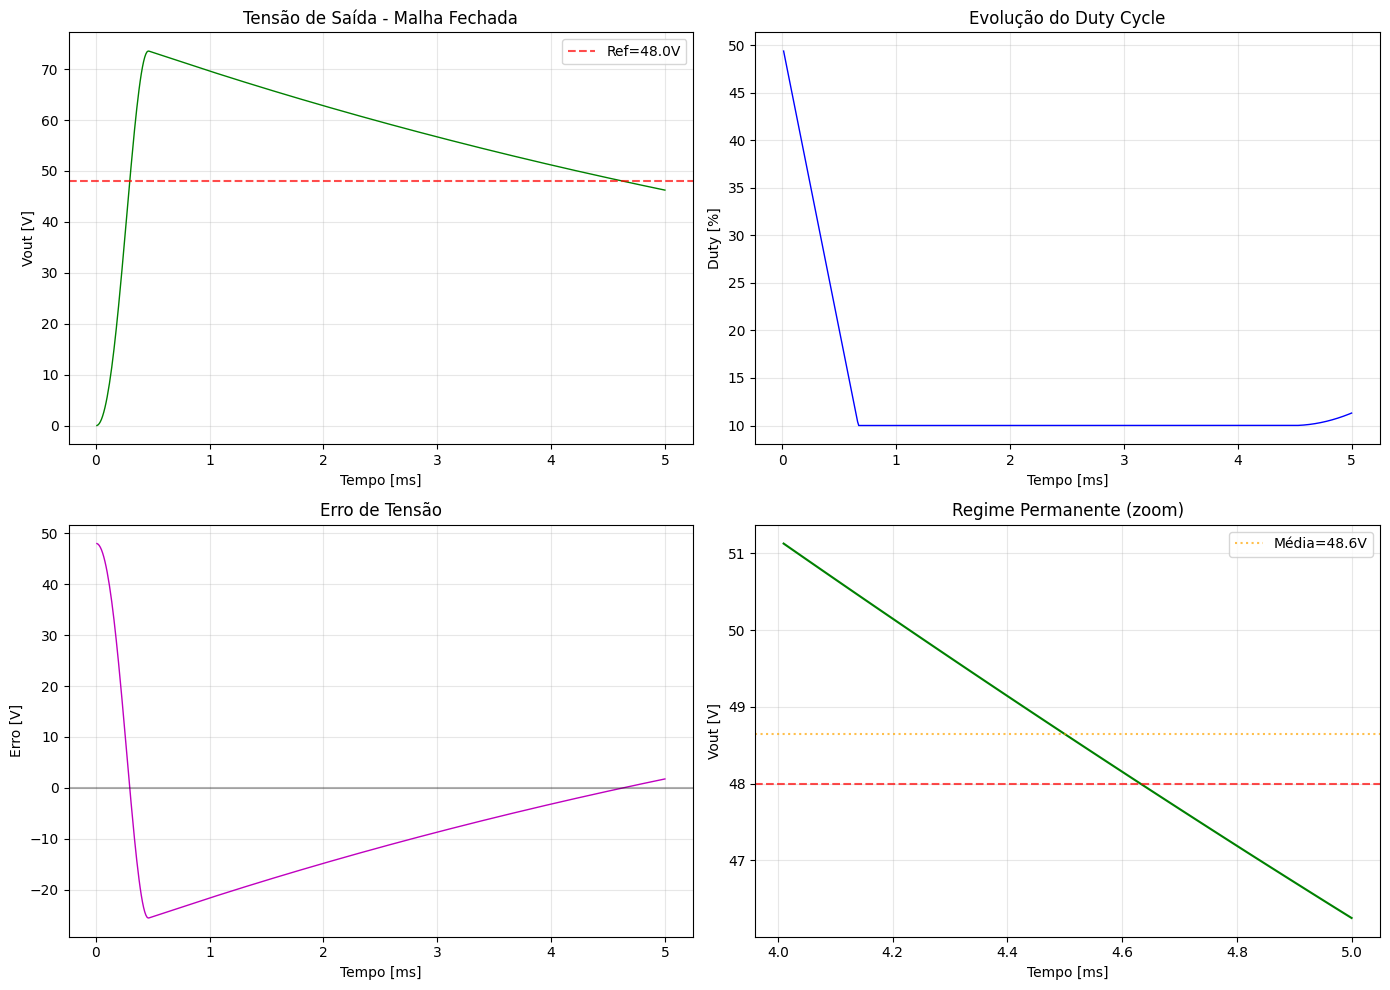

In [27]:
# ============================================================
# GRÁFICOS MALHA FECHADA
# ============================================================

if results_cl['success']:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    time_cl = results_cl['time']
    vout_cl = results_cl['vout']
    duty_cl = results_cl['duty']
    error_cl = results_cl['error']
    
    # Vout
    ax = axes[0, 0]
    ax.plot(time_cl, vout_cl, 'g-', linewidth=1)
    ax.axhline(Vout, color='r', linestyle='--', alpha=0.7, label=f'Ref={Vout}V')
    ax.set_xlabel('Tempo [ms]')
    ax.set_ylabel('Vout [V]')
    ax.set_title('Tensão de Saída - Malha Fechada')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Duty
    ax = axes[0, 1]
    ax.plot(time_cl, np.array(duty_cl)*100, 'b-', linewidth=1)
    ax.set_xlabel('Tempo [ms]')
    ax.set_ylabel('Duty [%]')
    ax.set_title('Evolução do Duty Cycle')
    ax.grid(True, alpha=0.3)
    
    # Erro
    ax = axes[1, 0]
    ax.plot(time_cl, error_cl, 'm-', linewidth=1)
    ax.axhline(0, color='k', linestyle='-', alpha=0.3)
    ax.set_xlabel('Tempo [ms]')
    ax.set_ylabel('Erro [V]')
    ax.set_title('Erro de Tensão')
    ax.grid(True, alpha=0.3)
    
    # Zoom Vout
    ax = axes[1, 1]
    ax.plot(time_cl[idx_st:], vout_cl[idx_st:], 'g-', linewidth=1.5)
    ax.axhline(Vout, color='r', linestyle='--', alpha=0.7)
    ax.axhline(vout_avg, color='orange', linestyle=':', alpha=0.7, label=f'Média={vout_avg:.1f}V')
    ax.set_xlabel('Tempo [ms]')
    ax.set_ylabel('Vout [V]')
    ax.set_title('Regime Permanente (zoom)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Resumo do Projeto

In [28]:
# ============================================================
# RESUMO FINAL
# ============================================================

print("="*60)
print("RESUMO DO PROJETO DO FLYBACK CONVERTER")
print("="*60)

print("\n1. ESPECIFICAÇÕES:")
print(f"   Vin: {Vin_min}V - {Vin_max}V (nominal {Vin_nom}V)")
print(f"   Vout: {Vout}V (isolado)")
print(f"   Pout: {Pout}W")
print(f"   fsw: {fsw/1e3:.0f}kHz")

print("\n2. COMPONENTES:")
print(f"   Transformador: {n}:1")
print(f"   Lm: {Lm*1e6:.0f}µH")
print(f"   Cout: {C_out*1e6:.0f}µF")
print(f"   Rload: {R_load:.1f}Ω")

print("\n3. CONTROLADOR PI:")
print(f"   Kp = {Kp}")
print(f"   Ki = {Ki}")

print("\n4. FUNÇÃO DE TRANSFERÊNCIA:")
print(f"   Vout = Vin / (n × (1-D))")
print(f"   Esta é uma topologia de boost isolado")

print("\n5. DESEMPENHO:")
try:
    if success:
        print(f"   Malha Aberta: Vout = {v_out_avg:.1f}V")
except:
    pass

try:
    if results_cl['success']:
        print(f"   Malha Fechada: Vout = {vout_avg:.1f}V (erro: {erro:+.2f}%)")
except:
    pass

print("\n" + "="*60)
print("PROJETO COMPLETO DO FLYBACK CONVERTER!")
print("="*60)

RESUMO DO PROJETO DO FLYBACK CONVERTER

1. ESPECIFICAÇÕES:
   Vin: 20.0V - 28.0V (nominal 24.0V)
   Vout: 48.0V (isolado)
   Pout: 24.0W
   fsw: 100kHz

2. COMPONENTES:
   Transformador: 1:1
   Lm: 100µH
   Cout: 100µF
   Rload: 96.0Ω

3. CONTROLADOR PI:
   Kp = 0.003
   Ki = 20.0

4. FUNÇÃO DE TRANSFERÊNCIA:
   Vout = Vin / (n × (1-D))
   Esta é uma topologia de boost isolado

5. DESEMPENHO:
   Malha Aberta: Vout = 48.7V
   Malha Fechada: Vout = 48.6V (erro: +1.34%)

PROJETO COMPLETO DO FLYBACK CONVERTER!
